# Proyecto de Machine Learning - Reconocimiento de Actividad Humana (HAR)
## MLEA 2025-II - Qwertylab.dev

**Integrantes:** 
*   Oscar A. Virguez

**Propósito del Notebook:**
El presente documento detalla el flujo de trabajo seguido para realizar una solución al dasafio, abarcando:

1.  **Análisis Exploratorio de Datos (EDA):** Comprensión de la distribución de clases y características de las señales.
2.  **Preprocesamiento e Ingeniería de Características:** Limpieza de datos, normalización y extracción de atributos relevantes para mejorar el desempeño de los modelos.
3.  **Modelado Predictivo:** Entrenamiento y evaluación de diversos algoritmos (incluyendo XGBoost y otros enfoques de aprendizaje supervisado).
4.  **Optimización y Selección:** Ajuste de hiperparámetros y selección del modelo óptimo balanceando precisión (*accuracy*) y eficiencia computacional.
5.  **Generación de Resultados:** Producción del archivo de predicciones para la competencia.

## Prerrequisitos

Para la correcta ejecución de este cuaderno, es necesario contar con las siguientes librerías instaladas en el entorno de Python:

*   `pandas`: Manipulación y análisis de datos.
*   `numpy`: Operaciones matemáticas y manejo de arrays.
*   `xgboost`: Algoritmo de Gradient Boosting para modelado.
*   `scikit-learn`: Herramientas de aprendizaje automático y métricas.
*   `matplotlib` & `seaborn`: Visualización de datos.

Puede instalar todas las dependencias ejecutando la siguiente celda.

In [2]:
%pip install pandas numpy xgboost scikit-learn matplotlib seaborn

Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.


## Variables Globales

A continuación se definen las constantes globales utilizadas en el proyecto, incluyendo la semilla aleatoria para reproducibilidad y el nombre del directorio de datos.

In [3]:
# Definición de variables globales
SEED = 3141
FOLDER_NAME = "mlea-challenge-2025-ii-ue"  # Directorio para los datos y nombre de la competencia

print(f"Semilla global definida: {SEED}")
print(f"Directorio de datos definido: {FOLDER_NAME}")

Semilla global definida: 3141
Directorio de datos definido: mlea-challenge-2025-ii-ue


## 1. Carga de Datos

Se procede a la carga de los conjuntos de datos. Los datos se descargarán automáticamente desde el repositorio público del curso en GitHub si no se encuentran disponibles localmente.

In [4]:
import os
import urllib.request

os.makedirs(FOLDER_NAME, exist_ok=True)
BASE_URL = "https://raw.githubusercontent.com/oscar243/mlea/main/mlea-challenge-2025-ii-ue/"
FILES = ["metadata.csv", "signals.csv", "metadata_test.csv", "signals_test.csv", "metadata_kaggle.csv", "signals_kaggle.csv", "predictions_sample.csv"]

for file in FILES:
    path = os.path.join(FOLDER_NAME, file)
    if not os.path.exists(path):
        print(f"Descargando {file}...")
        try:
            urllib.request.urlretrieve(BASE_URL + file, path)
        except Exception as e:
            print(f"Error descargando {file}: {e}")

print("Carga de datos completada." if all(os.path.exists(os.path.join(FOLDER_NAME, f)) for f in FILES) else "Advertencia: Faltan archivos.")

Carga de datos completada.


## 2. Unificación de Datos

En esta etapa, se cargan todos los archivos CSV (entrenamiento, prueba y kaggle) tanto de señales como de metadatos. Se crea una columna `data_source` para identificar el origen de cada registro y posteriormente se fusionan en un único DataFrame maestro. Esto facilita el preprocesamiento conjunto y la generación de características consistentes.

In [5]:
import pandas as pd

# Cargar archivos de señales
signals_train = pd.read_csv(os.path.join(FOLDER_NAME, 'signals.csv'))
signals_test = pd.read_csv(os.path.join(FOLDER_NAME, 'signals_test.csv'))
signals_kaggle = pd.read_csv(os.path.join(FOLDER_NAME, 'signals_kaggle.csv'))

# Cargar archivos de metadatos
metadata_train = pd.read_csv(os.path.join(FOLDER_NAME, 'metadata.csv'))
metadata_test = pd.read_csv(os.path.join(FOLDER_NAME, 'metadata_test.csv'))
metadata_kaggle = pd.read_csv(os.path.join(FOLDER_NAME, 'metadata_kaggle.csv'))

# Etiquetar la fuente de datos
signals_train['data_source'] = 'train'
signals_test['data_source'] = 'test'
signals_kaggle['data_source'] = 'kaggle'

metadata_train['data_source'] = 'train'
metadata_test['data_source'] = 'test'
metadata_kaggle['data_source'] = 'kaggle'

# Concatenar todos los conjuntos
all_signals = pd.concat([signals_train, signals_test, signals_kaggle], ignore_index=True)
all_metadata = pd.concat([metadata_train, metadata_test, metadata_kaggle], ignore_index=True)

# Fusionar señales y metadatos usando 'user_snippet' y 'data_source'
unified_data = pd.merge(all_signals, all_metadata, on=['user_snippet', 'data_source'], how='left')

# Verificación de la carga
print(f"Dimensiones del dataset unificado: {unified_data.shape}")
print("\nPrimeras filas del dataset:")
display(unified_data.head())

print("\nDistribución de registros por fuente de datos:")
print(unified_data['data_source'].value_counts())

Dimensiones del dataset unificado: (1073323, 37)

Primeras filas del dataset:


,user_snippet,x-axis,y-axis,z-axis,timestamp,data_source,x-axis__sum_values,x-axis__median,x-axis__mean,x-axis__length,...,z-axis__median,z-axis__mean,z-axis__length,z-axis__standard_deviation,z-axis__variance,z-axis__root_mean_square,z-axis__maximum,z-axis__absolute_maximum,z-axis__minimum,activity
0,525_0,1.57,-0.61,-0.65,0.0,train,-247.31,-1.805,-2.4731,100.0,...,-1.44,-2.2178,100.0,3.088071,9.536183,3.801949,2.91,12.95,-12.95,Jogging
1,525_0,-1.12,1.84,-1.46,50.0,train,-247.31,-1.805,-2.4731,100.0,...,-1.44,-2.2178,100.0,3.088071,9.536183,3.801949,2.91,12.95,-12.95,Jogging
2,525_0,5.48,14.14,-5.71,100.0,train,-247.31,-1.805,-2.4731,100.0,...,-1.44,-2.2178,100.0,3.088071,9.536183,3.801949,2.91,12.95,-12.95,Jogging
3,525_0,-12.41,10.53,-5.52,150.0,train,-247.31,-1.805,-2.4731,100.0,...,-1.44,-2.2178,100.0,3.088071,9.536183,3.801949,2.91,12.95,-12.95,Jogging
4,525_0,-1.14,10.50,2.91,200.0,train,-247.31,-1.805,-2.4731,100.0,...,-1.44,-2.2178,100.0,3.088071,9.536183,3.801949,2.91,12.95,-12.95,Jogging



Distribución de registros por fuente de datos:
data_source
train     629866
kaggle    250184
test      193273
Name: count, dtype: int64


## 3. Análisis Exploratorio de Datos (EDA)

En esta sección, realizaremos un análisis visual para comprender mejor la naturaleza de los datos. Nos enfocaremos en tres aspectos clave:
1.  **Balance de Clases:** Verificar la distribución de las actividades en el conjunto de entrenamiento.
2.  **Visualización de Señales:** Observar el comportamiento de las series de tiempo (acelerómetro en ejes x, y, z) para cada tipo de actividad.
3.  **Correlación de Metadatos:** Analizar las relaciones entre las características estadísticas extraídas para identificar redundancias.

/tmp/ipykernel_888095/1381927471.py:9: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(data=train_data[['user_snippet', 'activity']].drop_duplicates(), x='activity', palette='viridis')


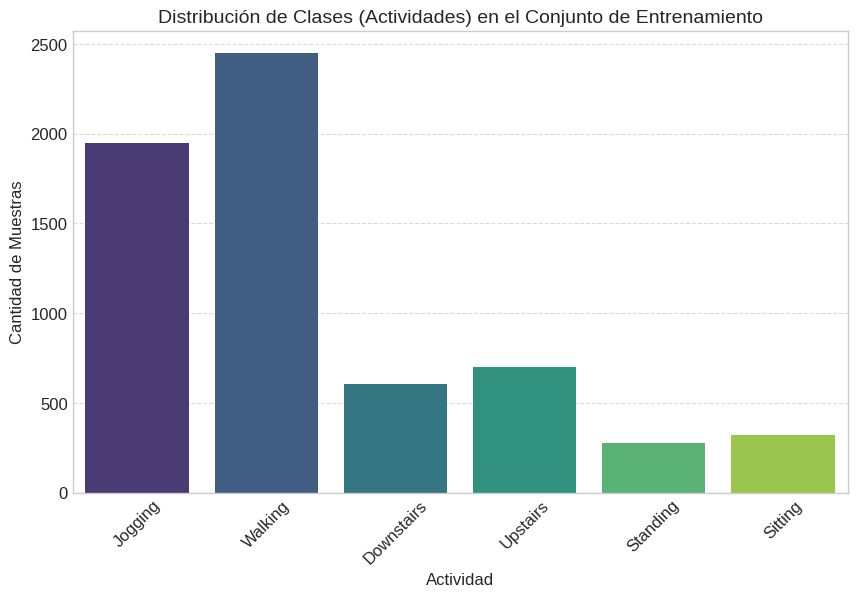

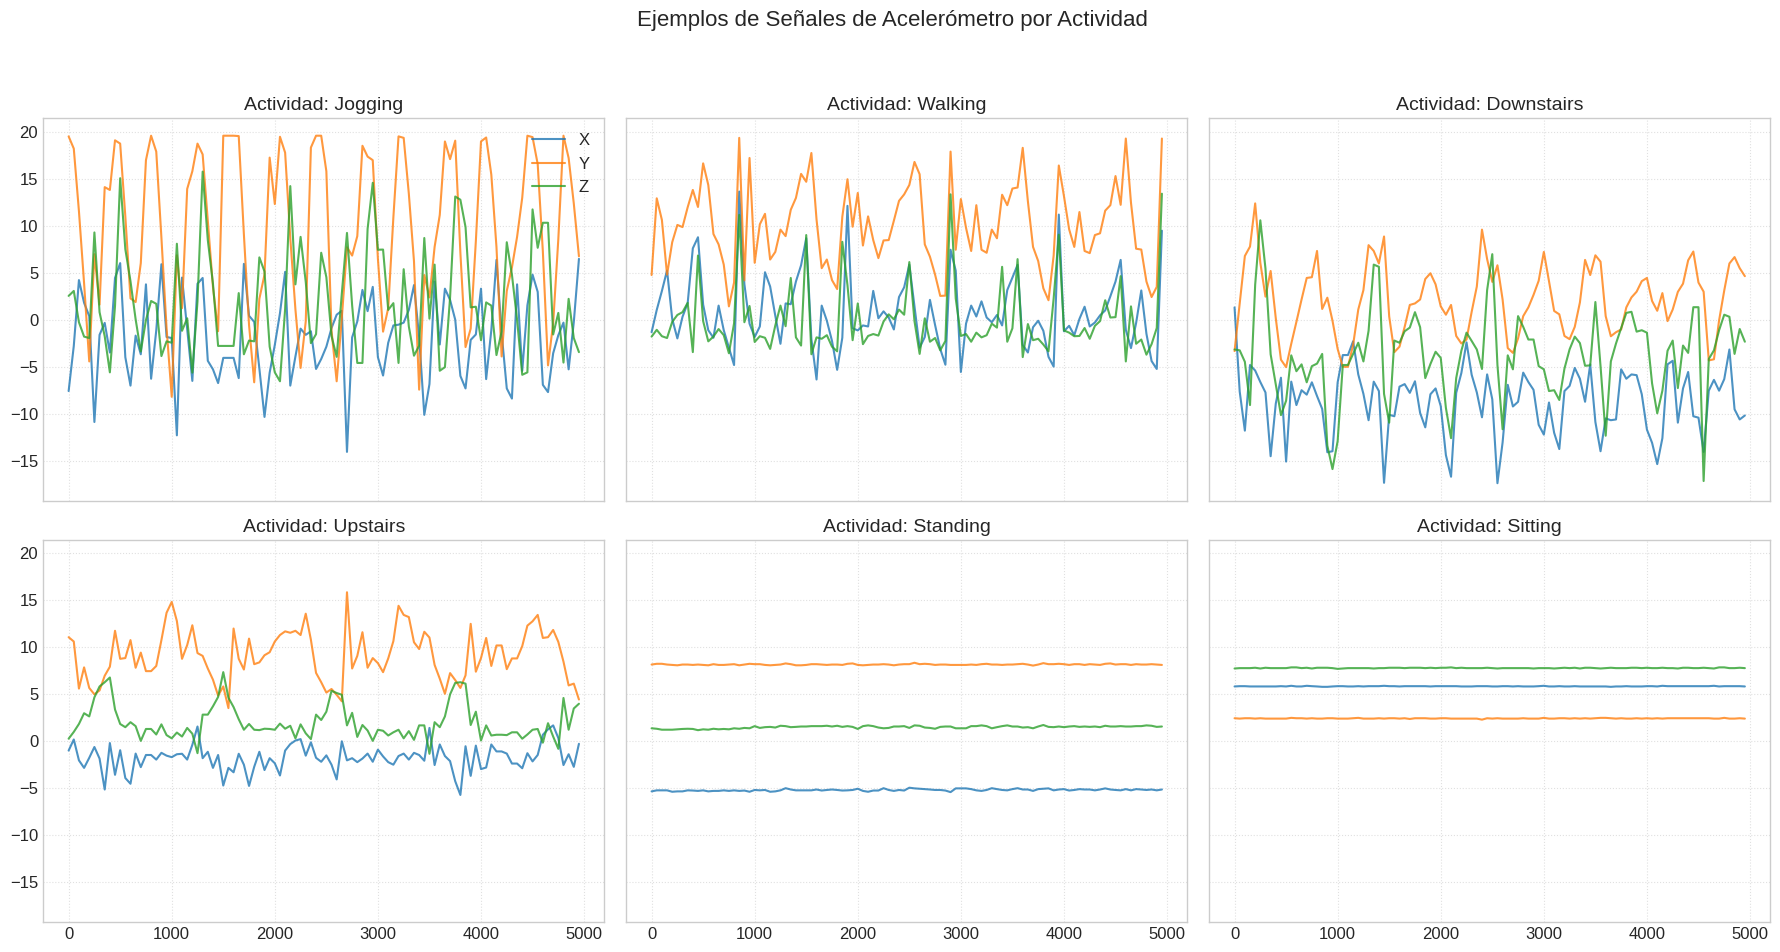

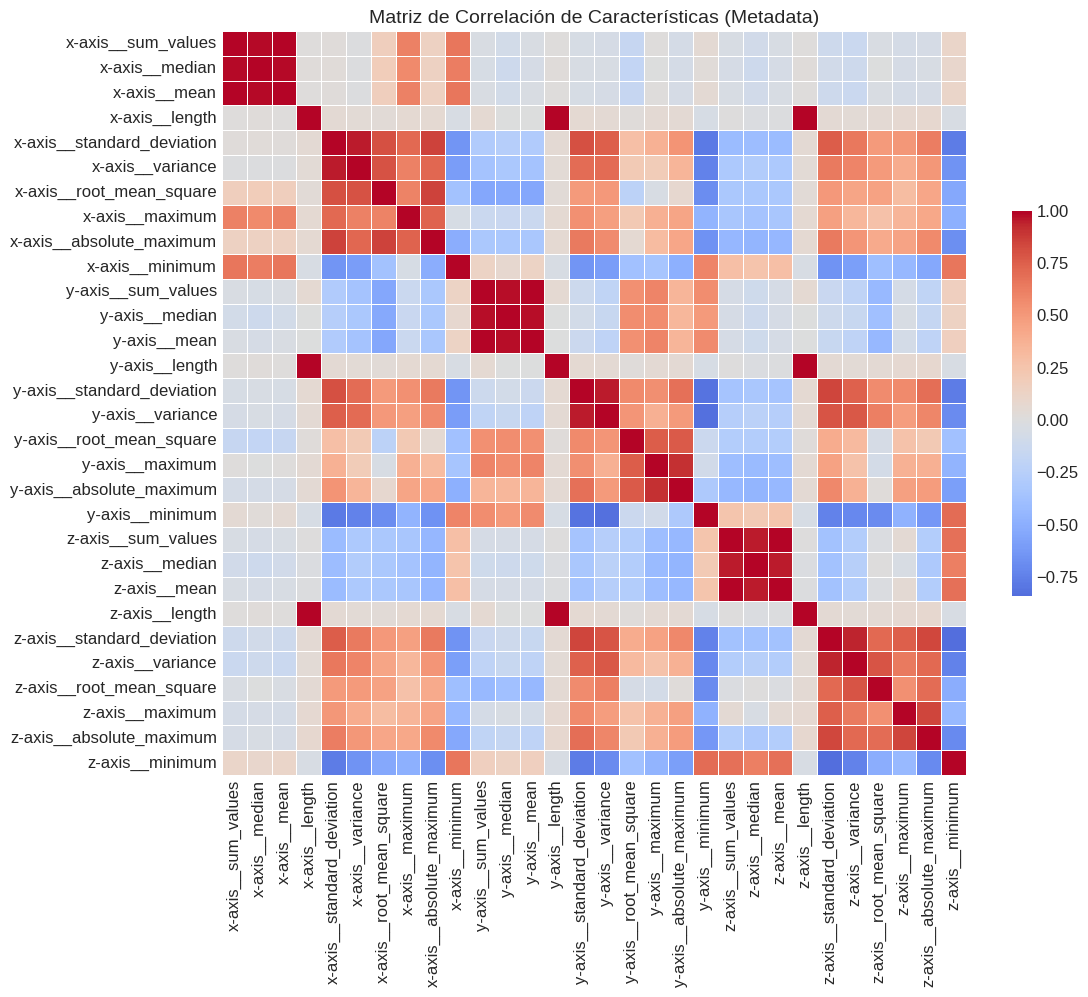

In [8]:
import matplotlib.pyplot as plt
import seaborn as sns

# Filtrar datos de entrenamiento para el análisis
train_data = unified_data[unified_data['data_source'] == 'train']

# 1. Visualización de Clases (Balance)
plt.figure(figsize=(10, 6))
sns.countplot(data=train_data[['user_snippet', 'activity']].drop_duplicates(), x='activity', palette='viridis')
plt.title('Distribución de Clases (Actividades) en el Conjunto de Entrenamiento')
plt.xlabel('Actividad')
plt.ylabel('Cantidad de Muestras')
plt.xticks(rotation=45)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

# 2. Visualización de Señales (Small Multiples)
activities = train_data['activity'].unique()
fig, axes = plt.subplots(nrows=2, ncols=3, figsize=(18, 10), sharex=True, sharey=True)
axes = axes.flatten()

for i, activity in enumerate(activities):
    # Seleccionar un snippet aleatorio para esta actividad
    snippet = train_data[train_data['activity'] == activity]['user_snippet'].sample(1, random_state=SEED).iloc[0]
    snippet_data = train_data[train_data['user_snippet'] == snippet].sort_values('timestamp')
    
    # Graficar ejes
    axes[i].plot(snippet_data['timestamp'], snippet_data['x-axis'], label='X', alpha=0.8)
    axes[i].plot(snippet_data['timestamp'], snippet_data['y-axis'], label='Y', alpha=0.8)
    axes[i].plot(snippet_data['timestamp'], snippet_data['z-axis'], label='Z', alpha=0.8)
    
    axes[i].set_title(f'Actividad: {activity}')
    axes[i].grid(True, linestyle=':', alpha=0.6)
    if i == 0:
        axes[i].legend(loc='upper right')

plt.suptitle('Ejemplos de Señales de Acelerómetro por Actividad', fontsize=16)
plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()

# 3. Análisis de Metadata (Matriz de Correlación)
# Seleccionar columnas numéricas de metadatos (excluyendo identificadores y señales crudas)
metadata_cols = [col for col in train_data.columns if 'axis' in col and col not in ['x-axis', 'y-axis', 'z-axis']]
# Tomamos una muestra para no sobrecargar el gráfico si son muchos datos, 
# pero como es metadata por snippet, primero debemos agrupar o usar el dataframe de metadata original.
# Usaremos metadata_train directamente para evitar duplicados por timestamp.

# Calcular correlación
corr_matrix = metadata_train[metadata_cols].corr()

plt.figure(figsize=(12, 10))
sns.heatmap(corr_matrix, cmap='coolwarm', center=0, square=True, linewidths=.5, cbar_kws={"shrink": .5})
plt.title('Matriz de Correlación de Características (Metadata)')
plt.show()

## 3.1 Análisis de Orientación (Scatter 3D)

Para verificar si la orientación del dispositivo varía entre muestras (efectos de rotación), visualizaremos los promedios de cada eje en un espacio tridimensional. Si actividades estáticas como "Standing" muestran una gran dispersión esférica en lugar de un clúster compacto, esto indicaría que la dirección de la gravedad cambia debido a la posición del sensor.

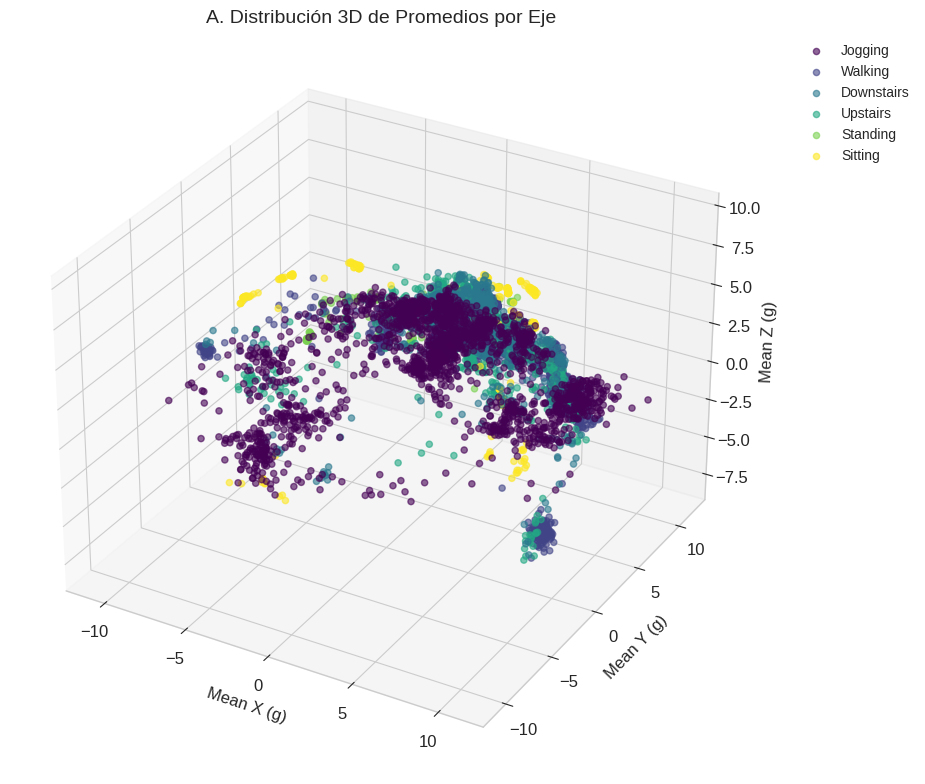

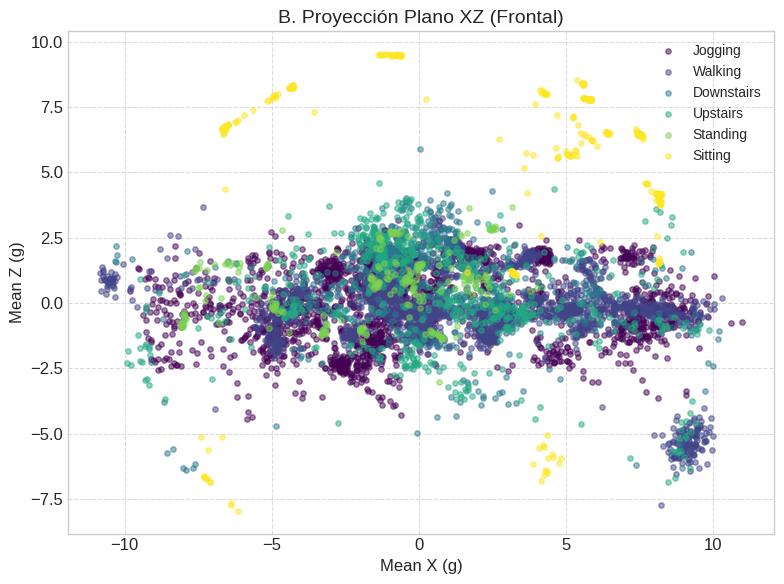

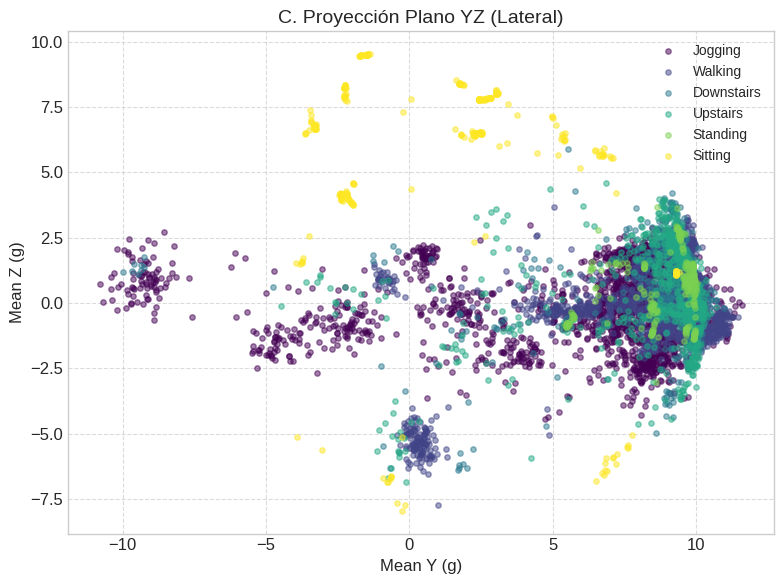

In [11]:
from mpl_toolkits.mplot3d import Axes3D
import numpy as np

# Configuración de estilo para gráficos científicos
plt.style.use('seaborn-v0_8-whitegrid')
plt.rcParams.update({'font.size': 12, 'figure.titlesize': 16, 'axes.titlesize': 14})

unique_activities = metadata_train['activity'].unique()
colors = plt.cm.viridis(np.linspace(0, 1, len(unique_activities)))
activity_color_map = dict(zip(unique_activities, colors))

# 1. Vista 3D Principal
fig1 = plt.figure(figsize=(10, 8))
ax1 = fig1.add_subplot(111, projection='3d')

for activity in unique_activities:
    subset = metadata_train[metadata_train['activity'] == activity]
    ax1.scatter(subset['x-axis__mean'], subset['y-axis__mean'], subset['z-axis__mean'], 
                label=activity, color=activity_color_map[activity], alpha=0.6, s=20)

ax1.set_xlabel('Mean X (g)')
ax1.set_ylabel('Mean Y (g)')
ax1.set_zlabel('Mean Z (g)')
ax1.set_title('A. Distribución 3D de Promedios por Eje')
ax1.legend(loc='upper left', bbox_to_anchor=(1.05, 1), fontsize='small')
plt.tight_layout()
plt.show()

# 2. Proyección XZ (Vista Frontal) - Z en vertical
fig2, ax2 = plt.subplots(figsize=(8, 6))
for activity in unique_activities:
    subset = metadata_train[metadata_train['activity'] == activity]
    ax2.scatter(subset['x-axis__mean'], subset['z-axis__mean'], 
                label=activity, color=activity_color_map[activity], alpha=0.5, s=15)
ax2.set_xlabel('Mean X (g)')
ax2.set_ylabel('Mean Z (g)')
ax2.set_title('B. Proyección Plano XZ (Frontal)')
ax2.grid(True, linestyle='--', alpha=0.7)
ax2.legend(loc='upper right', fontsize='small')
plt.tight_layout()
plt.show()

# 3. Proyección YZ (Vista Lateral) - Z en vertical
fig3, ax3 = plt.subplots(figsize=(8, 6))
for activity in unique_activities:
    subset = metadata_train[metadata_train['activity'] == activity]
    ax3.scatter(subset['y-axis__mean'], subset['z-axis__mean'], 
                label=activity, color=activity_color_map[activity], alpha=0.5, s=15)
ax3.set_xlabel('Mean Y (g)')
ax3.set_ylabel('Mean Z (g)')
ax3.set_title('C. Proyección Plano YZ (Lateral)')
ax3.grid(True, linestyle='--', alpha=0.7)
ax3.legend(loc='upper right', fontsize='small')
plt.tight_layout()
plt.show()

## 3.2 Análisis Específico: Actividad "Standing"

Para confirmar la hipótesis de que la orientación del dispositivo varía significativamente entre usuarios, aislaremos la actividad "Standing" (Estar de pie). En teoría, si el dispositivo estuviera siempre en la misma posición, la aceleración debida a la gravedad debería concentrarse en un solo eje (o una combinación constante). Si observamos una distribución esférica o dispersa, confirmaremos que el dispositivo se porta en diferentes orientaciones.

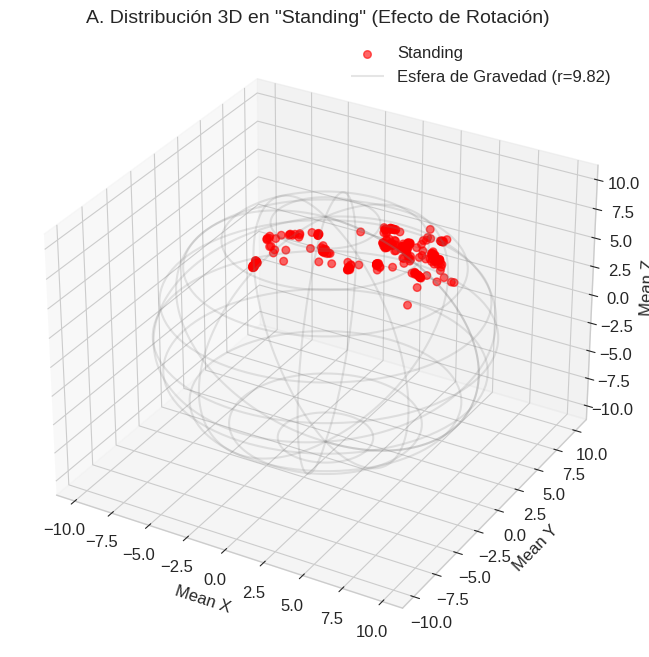

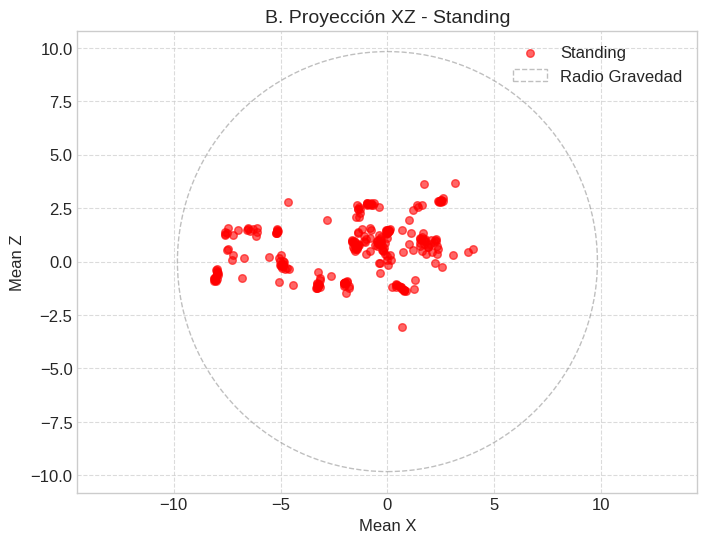

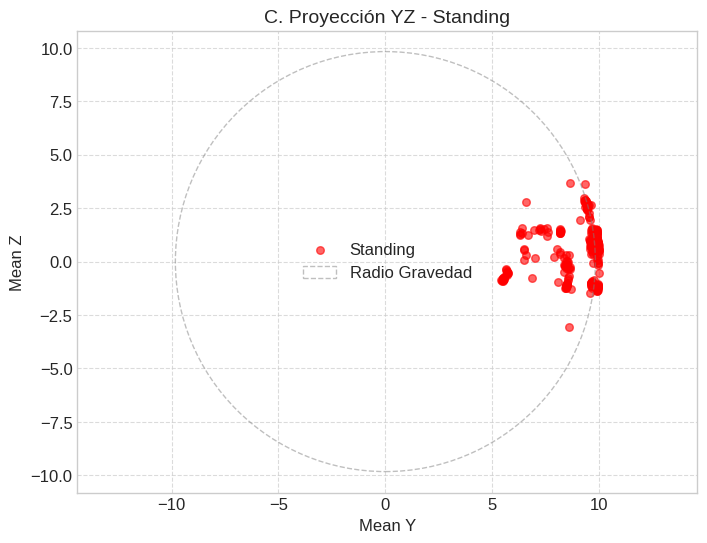

Magnitud promedio del vector de gravedad en 'Standing': 9.8226
Desviación estándar de la magnitud: 0.2736


In [30]:
# Filtrar solo la actividad 'Standing'
standing_data = metadata_train[metadata_train['activity'] == 'Standing']

# Calcular magnitud promedio para la esfera
magnitudes = np.sqrt(standing_data['x-axis__mean']**2 + standing_data['y-axis__mean']**2 + standing_data['z-axis__mean']**2)
avg_gravity = magnitudes.mean()

# 1. Vista 3D para Standing
fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection='3d')

# Graficar puntos
ax.scatter(standing_data['x-axis__mean'], 
           standing_data['y-axis__mean'], 
           standing_data['z-axis__mean'], 
           c='red', alpha=0.6, s=30, label='Standing')

# Crear malla para la esfera
u = np.linspace(0, 2 * np.pi, 100)
v = np.linspace(0, np.pi, 100)
x = avg_gravity * np.outer(np.cos(u), np.sin(v))
y = avg_gravity * np.outer(np.sin(u), np.sin(v))
z = avg_gravity * np.outer(np.ones(np.size(u)), np.cos(v))

# Graficar esfera de referencia
ax.plot_wireframe(x, y, z, color='gray', alpha=0.2, rstride=10, cstride=10, label=f'Esfera de Gravedad (r={avg_gravity:.2f})')

ax.set_xlabel('Mean X')
ax.set_ylabel('Mean Y')
ax.set_zlabel('Mean Z')
ax.set_title('A. Distribución 3D en "Standing" (Efecto de Rotación)')
ax.legend()
plt.show()

# 2. Proyección XZ para Standing - Z en vertical
fig2, ax2 = plt.subplots(figsize=(8, 6))
ax2.scatter(standing_data['x-axis__mean'], standing_data['z-axis__mean'], c='red', alpha=0.6, s=30, label='Standing')
# Círculo de referencia en 2D
circle = plt.Circle((0, 0), avg_gravity, color='gray', fill=False, linestyle='--', alpha=0.5, label='Radio Gravedad')
ax2.add_patch(circle)
ax2.set_xlabel('Mean X')
ax2.set_ylabel('Mean Z')
ax2.set_title('B. Proyección XZ - Standing')
ax2.grid(True, linestyle='--', alpha=0.7)
ax2.legend()
ax2.set_aspect('equal', adjustable='datalim')
plt.show()

# 3. Proyección YZ para Standing - Z en vertical
fig3, ax3 = plt.subplots(figsize=(8, 6))
ax3.scatter(standing_data['y-axis__mean'], standing_data['z-axis__mean'], c='red', alpha=0.6, s=30, label='Standing')
# Círculo de referencia en 2D
circle = plt.Circle((0, 0), avg_gravity, color='gray', fill=False, linestyle='--', alpha=0.5, label='Radio Gravedad')
ax3.add_patch(circle)
ax3.set_xlabel('Mean Y')
ax3.set_ylabel('Mean Z')
ax3.set_title('C. Proyección YZ - Standing')
ax3.grid(True, linestyle='--', alpha=0.7)
ax3.legend()
ax3.set_aspect('equal', adjustable='datalim')
plt.show()

print(f"Magnitud promedio del vector de gravedad en 'Standing': {avg_gravity:.4f}")
print(f"Desviación estándar de la magnitud: {magnitudes.std():.4f}")

### Uso de SVM (Signal Vector Magnitude)

El análisis anterior de la actividad "Standing" revela que, aunque el dispositivo tiende a mantener una orientación general, existen variaciones en la distribución de la gravedad entre los ejes (efectos de rotación). Para mitigar esto y extraer características invariantes a la rotación, utilizaremos la **Magnitud del Vector de Señal (SVM)**.

El SVM combina los tres ejes en una sola métrica de intensidad, descartando la información direccional y enfocándose puramente en la magnitud de la aceleración:

$$ SVM = \sqrt{x^2 + y^2 + z^2} $$

In [ ]:
# Visualización específica para Standing: Componentes vs SVM
# Objetivo: Demostrar cómo el SVM estabiliza la señal frente a rotaciones

# Seleccionar un snippet representativo de Standing
standing_snippet = train_data[train_data['activity'] == 'Standing']['user_snippet'].sample(1, random_state=SEED).iloc[0]
data_standing = train_data[train_data['user_snippet'] == standing_snippet].sort_values('timestamp')

# Calcular SVM
svm_standing = np.sqrt(data_standing['x-axis']**2 + data_standing['y-axis']**2 + data_standing['z-axis']**2)

plt.figure(figsize=(12, 6))

# Graficar componentes individuales
plt.plot(data_standing['timestamp'], data_standing['x-axis'], label='X-axis', alpha=0.5, linestyle='--')
plt.plot(data_standing['timestamp'], data_standing['y-axis'], label='Y-axis', alpha=0.5, linestyle='--')
plt.plot(data_standing['timestamp'], data_standing['z-axis'], label='Z-axis', alpha=0.5, linestyle='--')

# Graficar SVM
plt.plot(data_standing['timestamp'], svm_standing, label='SVM (Magnitud)', color='black', linewidth=2)

plt.title(f'Comparación: Ejes Individuales vs SVM en "Standing" (Snippet: {standing_snippet})')
plt.xlabel('Tiempo')
plt.ylabel('Aceleración (g)')
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.grid(True, linestyle=':', alpha=0.6)
plt.tight_layout()
plt.show()

print(f"Desviación Estándar Promedio Ejes: {data_standing[['x-axis', 'y-axis', 'z-axis']].std().mean():.4f}")
print(f"Desviación Estándar SVM: {svm_standing.std():.4f}")

## 3.3 Análisis de Comportamiento Temporal (Stationarity)

En esta sección visualizamos la "huella digital" de cada actividad superponiendo múltiples señales de **Magnitud del Vector de Señal (SVM)**.
El SVM se calcula como:
$$ SVM = \sqrt{x^2 + y^2 + z^2} $$

Esto nos permite observar la varianza intra-clase y patrones periódicos característicos (ej. pasos en "Walking" vs ruido en "Sitting").

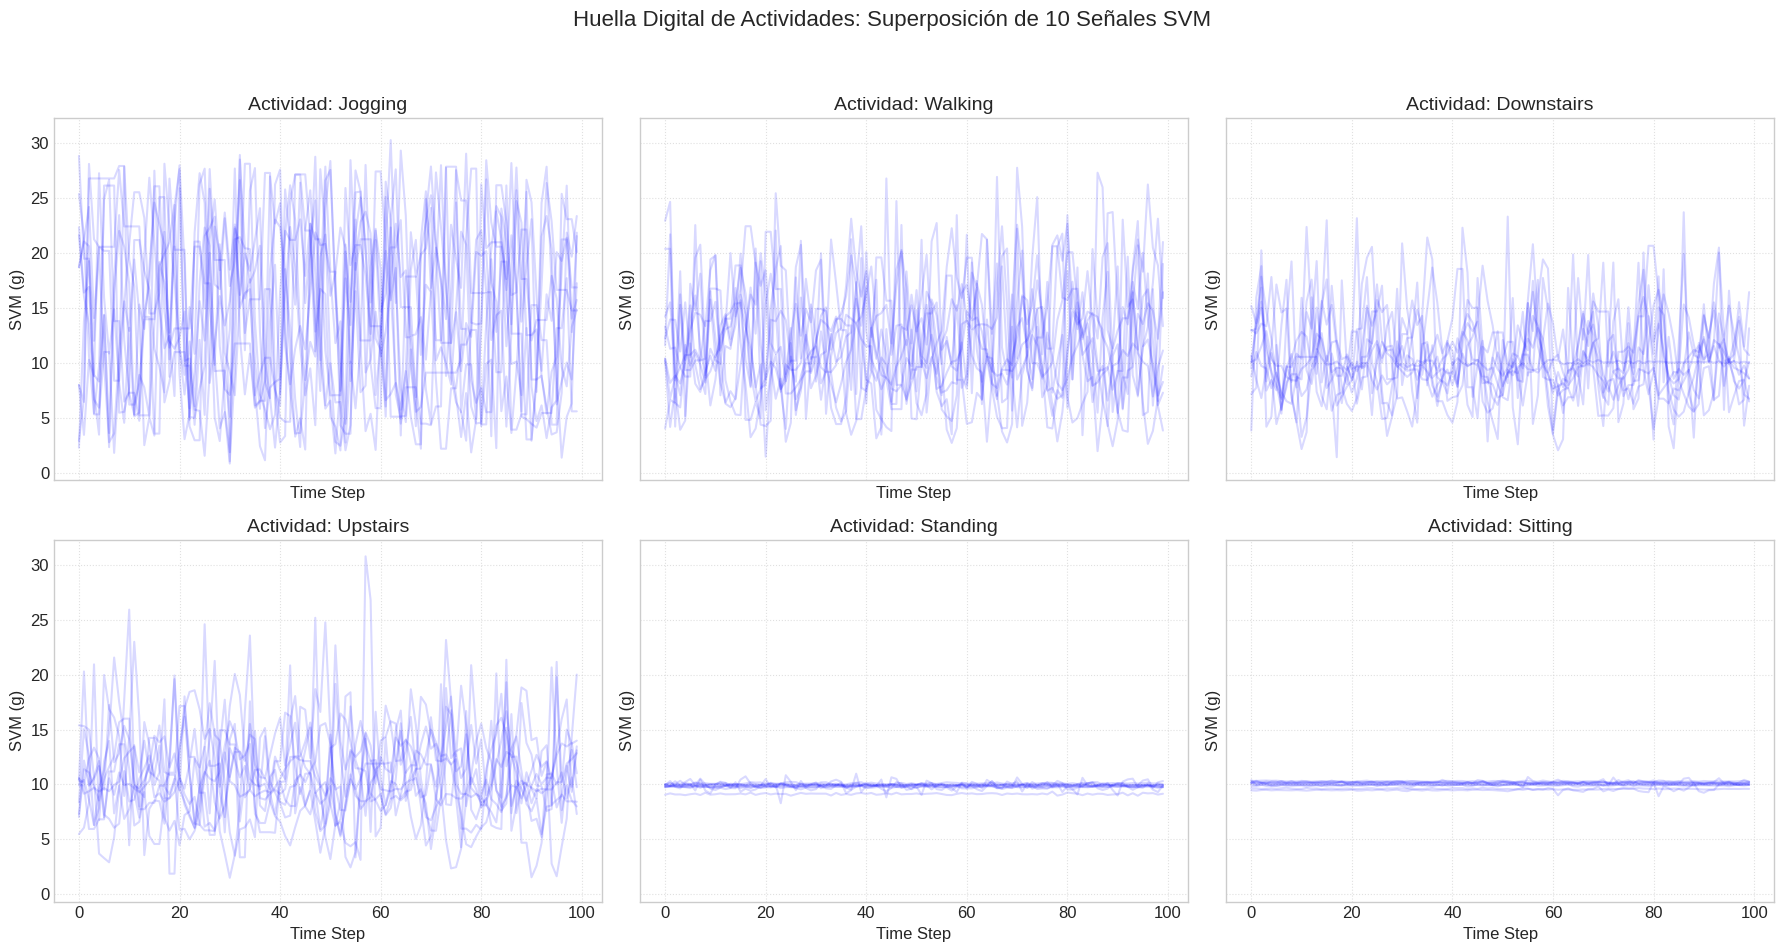

In [13]:
# Configuración de la figura
activities = train_data['activity'].unique()
fig, axes = plt.subplots(nrows=2, ncols=3, figsize=(18, 10), sharex=True, sharey=True)
axes = axes.flatten()

# Iterar sobre cada actividad
for i, activity in enumerate(activities):
    # Seleccionar 10 snippets aleatorios para esta actividad
    snippets = train_data[train_data['activity'] == activity]['user_snippet'].drop_duplicates().sample(10, random_state=SEED)
    
    # Graficar cada snippet
    for snippet in snippets:
        snippet_data = train_data[train_data['user_snippet'] == snippet].sort_values('timestamp')
        
        # Calcular SVM (Signal Vector Magnitude)
        svm = np.sqrt(snippet_data['x-axis']**2 + snippet_data['y-axis']**2 + snippet_data['z-axis']**2)
        
        # Normalizar tiempo para superponer (0 a N)
        time_steps = np.arange(len(svm))
        
        # Graficar
        axes[i].plot(time_steps, svm, color='blue', alpha=0.15, linewidth=1.5)
        
    axes[i].set_title(f'Actividad: {activity}')
    axes[i].set_xlabel('Time Step')
    axes[i].set_ylabel('SVM (g)')
    axes[i].grid(True, linestyle=':', alpha=0.6)

plt.suptitle('Huella Digital de Actividades: Superposición de 10 Señales SVM', fontsize=16)
plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()